# Approximation of function with TensorFlow using Sigmoids
The aim of this study is to approximate a given function using a neural network composed of weighted sums and sigmoids. It is an implementation of the paper of G. Cybenko [Approximation by Superpositions of a Sigmoidal Function](http://www.dartmouth.edu/~gvc/Cybenko_MCSS.pdf) (Mathematics of Control, Signals and Systems 1989).
Intuitively, each sigmoid can be seen as an increasing or decreasing edge of the approximated curve. Hence by superposing them, the different parts of the source curve can be re-constructed, as explained [visually](http://neuralnetworksanddeeplearning.com/chap4.html)

### Function to approximate

C:\Users\Ben\AppData\Local\Temp\ipykernel_16148\2223300980.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_data = np.array([ ( math.sin(float(i)/10) + float(i)*math.sin(float(i/3))/S ) for i in x_data], ndmin=2).T


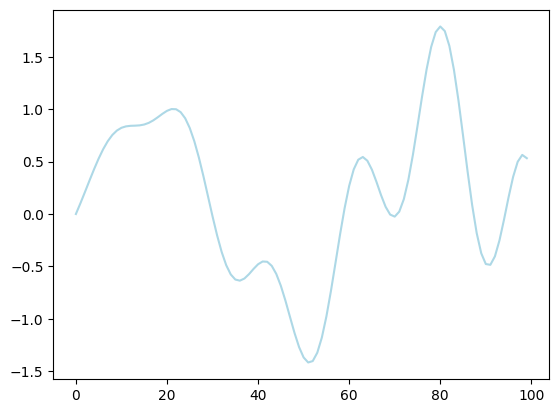

In [2]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import math

# Number of sample for the function definition
S=100

# Definition of the expected input and output of the function
x_data = np.array(list(range(S)), ndmin=2).T
y_data = np.array([ ( math.sin(float(i)/10) + float(i)*math.sin(float(i/3))/S ) for i in x_data], ndmin=2).T

# Displays curve
plt.plot(x_data, y_data, color = "lightblue")
plt.show()

### Computation model

The approximation function is of the following form (see Cybenko's paper), where $\sigma(x)$ is the sigmoid function, $w_i$ the basic weights, $b_i$ the biases, $W_i$ the final weights and $N$ the number of neurons:

$$ f(x) = \sum_{i=1}^{N}{W_i \sigma(w_i x + b_i)} $$

We represent the calculation using matrices as following, where $S$ is the size of the function samples. First the linear combinations from the input are computed (in the code, $b$ is a single line automatically expanded by broadcast):

$$
A=
\begin{bmatrix} x_{1} \\ x_{2} \\ \vdots \\ x_{S} \end{bmatrix}
.
\begin{bmatrix} w_{1} & w_{2} & \dots & w_{N} \end{bmatrix}
+
\begin{bmatrix}
  b_{1}  & b_{2}  & \dots  & b_{N}  \\
  b_{1}  & b_{2}  & \dots  & b_{N}  \\
  \vdots & \vdots & \vdots & \vdots \\
  b_{1}  & b_{2}  & \dots  & b_{N}
\end{bmatrix}
=
\begin{bmatrix}
  w_{1}x_{1}+b_{1}  & w_{2}x_{1}+b_{2}  & \dots & w_{N}x_{1}+b_{N}   \\
  w_{1}x_{2}+b_{1}  & w_{2}x_{2}+b_{2}  & \dots & w_{N}x_{2}+b_{N}   \\
  \vdots & \vdots & \ddots & \vdots \\
  w_{1}x_{S}+b_{1}  & w_{2}x_{S}+b_{2}  & \dots & w_{N}x_{S}+b_{N}  
\end{bmatrix}
$$

Then the sigmoid function is applied to each element of the matrix and final weights are multiplied ($*$ is the element-wise multiplication, and in the code $W$ is a single-line matrix expanded by broadcast):
$$
B=\sigma(A)*\begin{bmatrix}
  W_{1}  & W_{2}  & \dots  & W_{N}  \\
  W_{1}  & W_{2}  & \dots  & W_{N}  \\
  \vdots & \vdots & \vdots & \vdots \\
  W_{1}  & W_{2}  & \dots  & W_{N}  \\
\end{bmatrix}
=
\begin{bmatrix}
  W_{1}\sigma(w_{1}x_{1}+b_{1}) & W_{2}\sigma(w_{2}x_{1}+b_{2}) & \dots & W_{N}\sigma(w_{N}x_{1}+b_{N}) \\
  W_{1}\sigma(w_{1}x_{2}+b_{1}) & W_{2}\sigma(w_{2}x_{2}+b_{2}) & \dots & W_{N}\sigma(w_{N}x_{2}+b_{N}) \\
  \vdots & \vdots & \ddots & \vdots \\
  W_{1}\sigma(w_{1}x_{S}+b_{1}) & W_{2}\sigma(w_{2}x_{S}+b_{2}) & \dots & W_{N}\sigma(w_{N}x_{S}+b_{N})  
\end{bmatrix}
$$





Finally, we sum the elements on each line using `reduce_sum`:
$$
y = \begin{bmatrix} \sum_{i=1}^{N}B_{1,i} \\ \sum_{i=1}^{N}B_{2,i} \\ \vdots \\ \sum_{i=1}^{N}B_{S,i} \end{bmatrix}
=
\begin{bmatrix}
  \sum_{i=1}^{N}W_{i}\sigma(w_{i}x_{1}+b_{i}) \\
  \sum_{i=1}^{N}W_{i}\sigma(w_{i}x_{2}+b_{i}) \\
  \vdots                                      \\
  \sum_{i=1}^{N}W_{i}\sigma(w_{i}x_{S}+b_{i}) \\
\end{bmatrix}
$$

### Creation of the TensorFlow graph
We choose the initial values for the biases $b_i$ and $w_i$ such that the sigmoids are distributed in the definition interval of the function (`x_data` list).



Shapes  x: (100, 1)  w: (1, 32)  b: (1, 32)  W: (1, 32)


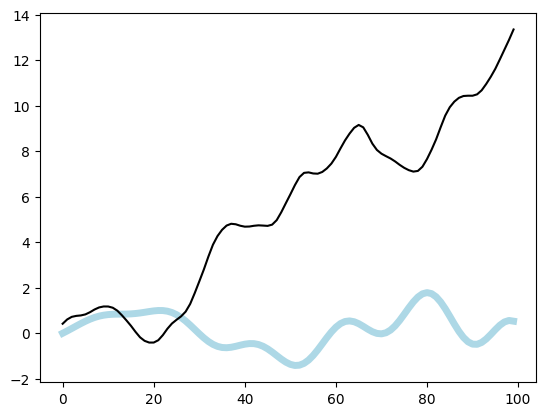

In [3]:
import tensorflow

tensorflow.compat.v1.disable_eager_execution()

# Number of neurons
N = 32

# Resets graph in case session was not close from past runs in notebook
tensorflow.compat.v1.reset_default_graph()

# Input vector
x = tensorflow.compat.v1.placeholder("float", [S,1], name="x")

# Weights and biases
w = tensorflow.compat.v1.Variable(tensorflow.compat.v1.ones([1,N]), dtype=tensorflow.compat.v1.float32, name="w")
b = tensorflow.compat.v1.Variable(np.linspace(-max(x_data), -min(x_data), N).reshape(1,N), dtype=tensorflow.compat.v1.float32, name="b")
W = tensorflow.compat.v1.Variable(np.random.uniform(-2.0, 2.0, size=(1,N)), dtype=tensorflow.compat.v1.float32, name="W")

# Intermediate matrix, b is automatically expanded by broadcast
A = tensorflow.compat.v1.matmul(x, w) + b

# Weighted sum of sigmoids, W is automatically expanded by broadcast
B = tensorflow.compat.v1.sigmoid(A)*W

# Final result by reducing one dimension of B
y = tensorflow.compat.v1.reshape(tensorflow.compat.v1.reduce_sum(B, 1), [S,1])

# Defines the loss function to optimize
loss = tensorflow.compat.v1.reduce_mean(tensorflow.compat.v1.square(y - y_data))

# Defines the op for initialization of the variables
init = tensorflow.compat.v1.global_variables_initializer()

# Plots initial approximated function
plt.plot(x_data, y_data, linewidth=5, color = "lightblue")
with tensorflow.compat.v1.Session() as sess:
    sess.run(init)
    plt.plot(y.eval(feed_dict={x: x_data}), color="black")

print("Shapes  x:", x.shape, " w:", w.shape, " b:", b.shape, " W:", W.shape)


### Training and animated results

Sample points: 100  Neurons: 32  Iterrations: 10000  Learning rate: 0.009  Final loss: 0.0039411243


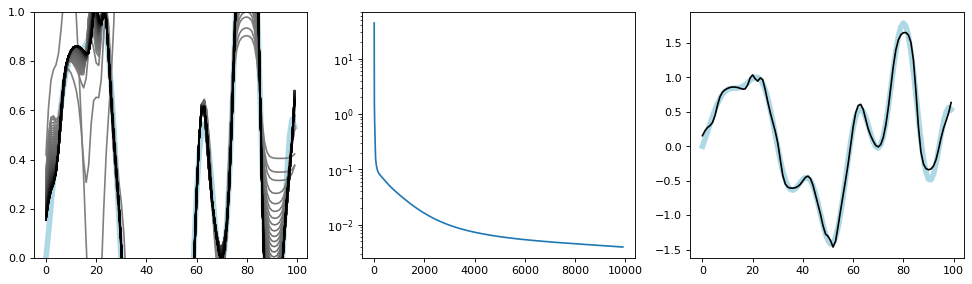

In [5]:
# Number of training steps
T = 10000
RATE = 0.009

# Initializes several plots
(fig, (curve_evolution, loss_evolution, final_curve)) = plt.subplots(1, 3, figsize=(15, 4), dpi= 80)
curve_evolution.plot(x_data, y_data, linewidth=5, color="lightblue")
curve_evolution.set_autoscaley_on(False)

# Initializes optimizer
optimizer = tensorflow.compat.v1.train.GradientDescentOptimizer(RATE)
#optimizer = tensorflow.compat.v1.train.AdamOptimizer(0.001)
train = optimizer.minimize(loss)
losses=list()

# Opens session
with tensorflow.compat.v1.Session() as sess:

    # Initializes global variables
    sess.run(init)

    for step in range(T):

        # Trains network and retrieves results
        (cur_train, cur_loss, cur_y, cur_W, cur_w, cur_b) = \
        sess.run([train, loss, y, W, w, b], feed_dict={x: x_data})
        losses.append(cur_loss)


        # Updates the results 100 times during the training
        if step % int(T/100) == 0:

            # Updates the curve evolution if not too far away from final curve
            curve_evolution.plot(x_data, cur_y, color=str(0.5-step/T/2))

            # Updates the loss plot
            loss_evolution.clear()
            loss_evolution.set_yscale("log")
            loss_evolution.plot(losses)

            # Updates the final curve as an animation
            final_curve.clear()
            final_curve.plot(x_data, y_data, linewidth=5, color="lightblue")
            final_curve.plot(x_data, cur_y, color="black")

            # Clears output and displays the figure
            display.display(plt.gcf())
            display.clear_output(wait=True)

# Prints global parameters of the model
print("Sample points:", S, " Neurons:", N, " Iterrations:", T, " Learning rate:", RATE, " Final loss:", cur_loss)